# Using elasticsearch fuzzy match and machine learning methods to categorise short text descriptions

Prerequisites:
- setup virtual env: `python -m venv <your_new_virtual_environment_name>`
- activate virtual env: `source <your_new_virtual_environment_name>`
- clone and install this repo `pip install git+https://github.com/chilledgeek/elasticsearch-simple-client.git`
- install extra packages for machine learning: `pip install tensorflow matplotlib scikit-learn xgboost`
- have a running elasticsearch docker image: 
  - `sudo docker pull elasticsearch:7.5.2`
  - `sudo docker run -d --name elasticsearch -p 9200:9200 -p 9300:9300 -e "discovery.type=single-node" elasticsearch:7.5.2` 
  - (`-d` runs command line in background)
- If required, clear out previous data on elasticsearch with: `curl -X DELETE "localhost:9200/<index_name>"`

In [1]:
!curl -X DELETE "localhost:9200/simple_text"

{"acknowledged":true}

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation (mainly for machine learning techniques)

### Load data

In [3]:
import pandas as pd

filepath = "./descriptions_with_categories.csv"
df = pd.read_csv(filepath)
df.head()

,description,annotated_category
0,ABOKADO HOLBORN LONDON GBR,EAT OUT
1,ABOKADO LONDON WCXV,EAT OUT
2,ACCOUNT TRANSFER,BANK TRANSFER
3,ADDED GROSS INT,INTEREST
4,ADDED NET INT,INTEREST


#### Filter out categories that have less than 10 annotated entries

In [4]:
indices_of_interest = df["annotated_category"].value_counts()[df["annotated_category"].value_counts() >= 10 ].index

In [5]:
df = df[df["annotated_category"].isin(indices_of_interest)]

### Label encode categories and apply to category

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(["UNKNOWN"] + list(df["annotated_category"])) # Add an extra UNKNOWN label in case outcome cannot be predicted

LabelEncoder()

In [7]:
df["annotated_category (encoded)"] = le.transform(df["annotated_category"])
df.head()

,description,annotated_category,annotated_category (encoded)
0,ABOKADO HOLBORN LONDON GBR,EAT OUT,3
1,ABOKADO LONDON WCXV,EAT OUT,3
2,ACCOUNT TRANSFER,BANK TRANSFER,0
6,ADVICE CONFIRMS GBSXXXXXAOSZK SURNAME NAME,BANK TRANSFER,0
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,0


### Split data to train and test sets

In [8]:
raw_train = df.sample(frac=0.8).sort_index()
raw_train.head()

,description,annotated_category,annotated_category (encoded)
0,ABOKADO HOLBORN LONDON GBR,EAT OUT,3
1,ABOKADO LONDON WCXV,EAT OUT,3
2,ACCOUNT TRANSFER,BANK TRANSFER,0
6,ADVICE CONFIRMS GBSXXXXXAOSZK SURNAME NAME,BANK TRANSFER,0
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,0


In [9]:
raw_test = df[~df.index.isin(raw_train.index)]
raw_test.head()

,description,annotated_category,annotated_category (encoded)
11,ALDI CANTERBURY,GROCERIES,6
14,SURNAME INITIALS FOOD FP XX/XX/XX XXXX RPXXXXX...,BANK TRANSFER,0
17,ALL BAR ONE OXFORD OXFORD XXXXX,EAT OUT,3
29,AMAZON UK RETAIL AMAZON.CO.UK,GENERAL RETAIL,5
39,APPLE ITUNES STORE GBP LUXEMBURG,ENTERTAINMENT,4


In [10]:
print(f"training entries: {len(raw_train)}")
print(f"test entries: {len(raw_test)}")
print(f"number of unique categories (with enough annotations): {len(set(df['annotated_category']))}")

training entries: 301
test entries: 75
number of unique categories (with enough annotations): 12


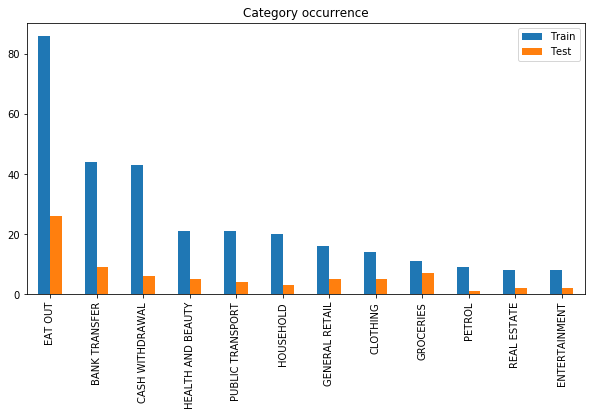

In [11]:
accumulated_category_count_df = pd.concat([
    raw_train["annotated_category"].value_counts(),
    raw_test["annotated_category"].value_counts()], 
    axis=1, 
    sort=False,
    keys = ["Train", "Test"])
accumulated_category_count_df.plot(kind="bar", figsize=(10,5), title="Category occurrence")

#### Create a bag of words using a count vectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

desc_vectorizer = CountVectorizer(analyzer="word", max_features=100)

training_bag_of_words = desc_vectorizer.fit_transform(raw_train["description"])

x_train = pd.DataFrame(training_bag_of_words.toarray(),
                       columns=[x for x in desc_vectorizer.get_feature_names()]).astype(int)

x_train.head()

,advice,amazon,and,aprxx,argos,asda,ashford,atm,augxx,bar,...,ticket,trm,uk,west,xx,xxjul,xxx,xxxx,xxxxxx,xxxxxxxxxxxxxxxxxn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_bag_of_words = desc_vectorizer.transform(raw_test["description"])

x_test = pd.DataFrame(test_bag_of_words.toarray(),
                      columns=[x for x in desc_vectorizer.get_feature_names()]).astype(int)
x_test.head()

,advice,amazon,and,aprxx,argos,asda,ashford,atm,augxx,bar,...,ticket,trm,uk,west,xx,xxjul,xxx,xxxx,xxxxxx,xxxxxxxxxxxxxxxxxn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (301, 100)
Shape of x_test: (75, 100)


## Model building

### Neural Network

In [15]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Input(shape=(100,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(len(set(df["annotated_category"])) + 1, activation='softmax') # extra unit for "UNKNOWN" tag
])

/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/dino/venv/test_es/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensor

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(x_train.values, raw_train["annotated_category (encoded)"], epochs=100)

Epoch 1/100
301/301 [==============================] - 0s 444us/sample - loss: 2.5628 - acc: 0.0864
Epoch 2/100
301/301 [==============================] - 0s 146us/sample - loss: 2.5602 - acc: 0.1196
Epoch 3/100
301/301 [==============================] - 0s 230us/sample - loss: 2.5574 - acc: 0.1927
Epoch 4/100
301/301 [==============================] - 0s 103us/sample - loss: 2.5545 - acc: 0.2060
Epoch 5/100
301/301 [==============================] - 0s 187us/sample - loss: 2.5513 - acc: 0.2326
Epoch 6/100
301/301 [==============================] - 0s 119us/sample - loss: 2.5475 - acc: 0.2724
Epoch 7/100
301/301 [==============================] - 0s 321us/sample - loss: 2.5434 - acc: 0.3488
Epoch 8/100
301/301 [==============================] - 0s 175us/sample - loss: 2.5383 - acc: 0.3754
Epoch 9/100
301/301 [==============================] - 0s 121us/sample - loss: 2.5325 - acc: 0.3920
Epoch 10/100
301/301 [==============================] - 0s 135us/sample - loss: 2.5258 - acc: 0.3987

301/301 [==============================] - 0s 132us/sample - loss: 1.9468 - acc: 0.7708
Epoch 83/100
301/301 [==============================] - 0s 100us/sample - loss: 1.9439 - acc: 0.7708
Epoch 84/100
301/301 [==============================] - 0s 106us/sample - loss: 1.9411 - acc: 0.7708
Epoch 85/100
301/301 [==============================] - 0s 109us/sample - loss: 1.9389 - acc: 0.7774
Epoch 86/100
301/301 [==============================] - 0s 117us/sample - loss: 1.9367 - acc: 0.7807
Epoch 87/100
301/301 [==============================] - 0s 125us/sample - loss: 1.9346 - acc: 0.7807
Epoch 88/100
301/301 [==============================] - 0s 144us/sample - loss: 1.9328 - acc: 0.7841
Epoch 89/100
301/301 [==============================] - 0s 109us/sample - loss: 1.9309 - acc: 0.7841
Epoch 90/100
301/301 [==============================] - 0s 109us/sample - loss: 1.9291 - acc: 0.7841
Epoch 91/100
301/301 [==============================] - 0s 116us/sample - loss: 1.9275 - acc: 0.7874
Epo

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, raw_train["annotated_category (encoded)"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### XGBoost

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, raw_train["annotated_category (encoded)"])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### Elasticsearch

##### Upload training data (descriptions + category) to elasticsearch

In [20]:
from elasticsearch_simple_client.uploader import Uploader

es_uploader = Uploader()
es_uploader.post_df(raw_train[["description","annotated_category"]])

#### Query test data and lookup nearest (fuzzy) match to training data and get corresponding category

In [21]:
import time
time.sleep(5) # allow time for elasticsearch indices to be updated

In [22]:
from elasticsearch_simple_client.searcher import Searcher

searcher = Searcher()
es_category_lookup_on_train_data = []

for entry in raw_train["description"]:
    result = searcher.execute_search(field="description",
                                     shoulds=[entry])["hits"]["hits"]
    predicted_category = result[0]["_source"]["annotated_category"]
    es_category_lookup_on_train_data.append(predicted_category)

In [23]:
es_category_lookup_on_test_data = []

for entry in raw_test["description"]:
    result = searcher.execute_search(field="description",
                                     shoulds=[entry])["hits"]["hits"]
    if len(result) > 0:
        es_category_lookup_on_test_data.append(result[0]["_source"]["annotated_category"])
    else:
        es_category_lookup_on_test_data.append("UNKNOWN")

## Analysis

In [24]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [25]:
def analysis_result(model_name, 
                    train_prediction,
                    train_target,
                    test_prediction, 
                    test_target):
    results = dict()
    results["model"] = model_name
    results["train_accuracy"] = accuracy_score(train_prediction, train_target)
    results["balanced_train_accuracy"] = balanced_accuracy_score(train_prediction, train_target)
    results["test_accuracy"] = accuracy_score(test_prediction, test_target)
    results["balanced_test_accuracy"] = balanced_accuracy_score(test_prediction, test_target)

    for key, value in results.items():
        if isinstance(value, str):
            print(f"\n{value}")
        else:
            print(f"\t{key}: {'{:.2f}'.format(value)}")
    
    return results

In [26]:
accumulated_results = []

train_pred_nn = [list(x).index(max(x)) for x in model.predict(x_train)]
test_pred_nn = [list(x).index(max(x)) for x in model.predict(x_test)]

accumulated_results.append(analysis_result("Neural Network", 
                                           train_pred_nn, 
                                           raw_train['annotated_category (encoded)'],               
                                           test_pred_nn, 
                                           raw_test['annotated_category (encoded)']))

train_pred_rf = rf.predict(x_train)
test_pred_rf = rf.predict(x_test)

accumulated_results.append(analysis_result("Random Forest", 
                                           train_pred_rf, 
                                           raw_train['annotated_category (encoded)'],
                                           test_pred_rf, 
                                           raw_test['annotated_category (encoded)']))

train_pred_xgb = xgb.predict(x_train)
test_pred_xgb = xgb.predict(x_test)

accumulated_results.append(analysis_result("XGBoost", 
                                           train_pred_xgb, 
                                           raw_train['annotated_category (encoded)'],
                                           test_pred_xgb, 
                                           raw_test['annotated_category (encoded)']))

train_pred_es = le.transform(es_category_lookup_on_train_data)
test_pred_es = le.transform(es_category_lookup_on_test_data)

accumulated_results.append(analysis_result("Elasticsearch", 
                                           train_pred_es, 
                                           raw_train['annotated_category (encoded)'],
                                           test_pred_es, 
                                           raw_test['annotated_category (encoded)']))


Neural Network
	train_accuracy: 0.80
	balanced_train_accuracy: 0.90
	test_accuracy: 0.75
	balanced_test_accuracy: 0.86

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.93
	test_accuracy: 0.79
	balanced_test_accuracy: 0.77

XGBoost
	train_accuracy: 0.86
	balanced_train_accuracy: 0.90
	test_accuracy: 0.73
	balanced_test_accuracy: 0.81

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.76
	balanced_test_accuracy: 0.68


/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


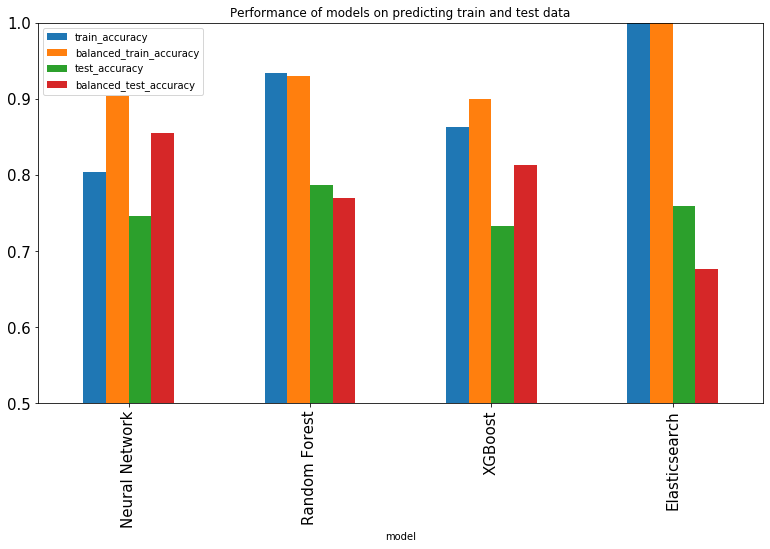

In [27]:
model_results_df = pd.DataFrame(accumulated_results)
model_results_df.set_index("model").plot(
    kind="bar", figsize=(13,7), ylim=(0.5,1), fontsize=15, 
    title="Performance of models on predicting train and test data"
)

In [28]:
raw_train.loc[:,"nn_prediction"] = le.inverse_transform(train_pred_nn)
raw_test.loc[:,"nn_prediction"] = le.inverse_transform(test_pred_nn)

raw_train.loc[:,"rf_prediction"] = le.inverse_transform(train_pred_rf)
raw_test.loc[:,"rf_prediction"] = le.inverse_transform(test_pred_rf)

raw_train.loc[:,"xgb_prediction"] = le.inverse_transform(train_pred_xgb)
raw_test.loc[:,"xgb_prediction"] = le.inverse_transform(test_pred_xgb)

raw_train.loc[:,"es_prediction"] = es_category_lookup_on_train_data
raw_test.loc[:,"es_prediction"] = es_category_lookup_on_test_data

/home/dino/venv/test_es/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dino/venv/test_es/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
view_columns = [x for x in raw_train.keys() if x != "annotated_category (encoded)"]

In [30]:
raw_train[view_columns].head(10)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
0,ABOKADO HOLBORN LONDON GBR,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
1,ABOKADO LONDON WCXV,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
2,ACCOUNT TRANSFER,BANK TRANSFER,EAT OUT,REAL ESTATE,EAT OUT,BANK TRANSFER
6,ADVICE CONFIRMS GBSXXXXXAOSZK SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
8,ADVICE CONFIRMS GBSXXXXXXXXCG SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
9,ADVICE CONFIRMS GBSXXXXXXXXHC SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
10,ALDI,GROCERIES,EAT OUT,REAL ESTATE,EAT OUT,GROCERIES
12,SURNAME INITIALS BAKING FP XX/XX/XX XXXX RPXXX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
13,SURNAME INITIALS CIGGIES FP XX/XX/XX XXXX RPXX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER


In [31]:
raw_test[view_columns].head(10)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
11,ALDI CANTERBURY,GROCERIES,EAT OUT,EAT OUT,EAT OUT,GROCERIES
14,SURNAME INITIALS FOOD FP XX/XX/XX XXXX RPXXXXX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
17,ALL BAR ONE OXFORD OXFORD XXXXX,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
29,AMAZON UK RETAIL AMAZON.CO.UK,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
39,APPLE ITUNES STORE GBP LUXEMBURG,ENTERTAINMENT,EAT OUT,REAL ESTATE,EAT OUT,GROCERIES
54,ASDA PETROL/UPT XXXX CANTERBURY GBR,PETROL,EAT OUT,GROCERIES,HOUSEHOLD,GROCERIES
57,ASDA SUPERSTORE CANTERBURY GBR,GROCERIES,EAT OUT,GROCERIES,HOUSEHOLD,GROCERIES
67,B AND M RETAIL CANTERBURY,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
70,B AND Q CAMBRIDGE XXX,GENERAL RETAIL,EAT OUT,CLOTHING,EAT OUT,GENERAL RETAIL
80,BARCLAYS BNK XXFEB,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER


In [32]:
raw_train[view_columns].sample(n=20)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
71,B&M RETAIL CANTERBURY,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
166,CALL REF.NO. XXXX NEWNHAM COLLEGE,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
26,AMAZON SVCS EUROPE SAR AMAZON.CO.UK LUX,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
100,BEST MANGEL BAR & REST,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
324,EAT LTD CAMBRIDGE,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
395,IKEA LAKESIDE EXPRESS C WEST THURROCK,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD
116,BOOTS THE CHEMIST LONDON,HEALTH AND BEAUTY,HEALTH AND BEAUTY,HEALTH AND BEAUTY,HEALTH AND BEAUTY,HEALTH AND BEAUTY
439,LUL TICKET MACHINE-CHAN LONDON,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT
362,GAME RETAIL LTD CANTER CANTERBURY GBR,ENTERTAINMENT,GENERAL RETAIL,ENTERTAINMENT,ENTERTAINMENT,ENTERTAINMENT
79,BARCLAYS BNK XXDEC,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER


In [33]:
raw_test[view_columns].sample(n=20)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
211,CASH INFOCSH JUNXX DCPUK-ASHFOR@XX:XX,CASH WITHDRAWAL,CASH WITHDRAWAL,CASH WITHDRAWAL,CASH WITHDRAWAL,CASH WITHDRAWAL
406,JOHN LEWIS AT HOME LONDON,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
445,LUL TICKET OFFICE CANARY WHARF,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT
421,LAS IGUANAS LONDON,EAT OUT,EAT OUT,EAT OUT,EAT OUT,CLOTHING
280,CO-OP GROUP XXXXXX GRANTCHESTER,GROCERIES,PUBLIC TRANSPORT,GROCERIES,GROCERIES,GROCERIES
271,CINEWORLD.CO.UK TEL: XXXX XXX,ENTERTAINMENT,GENERAL RETAIL,ENTERTAINMENT,ENTERTAINMENT,GENERAL RETAIL
232,CAU CAMBRIDGE CAMBRIDGE GBR,EAT OUT,EAT OUT,EAT OUT,EAT OUT,HEALTH AND BEAUTY
259,SURNAME INITIALS HSBC MONEY FP XX/XX/XX XXXX X...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
14,SURNAME INITIALS FOOD FP XX/XX/XX XXXX RPXXXXX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
255,SURNAME INITIALS INITIALS SURNAME BGC,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER


### Run everything above again but with Kfold cross validation for better assessment of accuracy

#### Split dataset into 10 fold

In [34]:
from sklearn.model_selection import KFold

def split_dataset(x_data,y_data,n_splits):
    # shuffle true is important as the dataset is sorted by alphabetical order of the description column
    # if shuffle is false then the model will be trained on data very different to that of test!!!
    for train_index, test_index in KFold(n_splits, shuffle=True).split(x_data):
        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        yield x_train,y_train,x_test,y_test
        
cv_dataset = split_dataset(df[["description"]].values,
                           df["annotated_category (encoded)"].values,
                           10)


- The following is bad coding but i couldn't be bothered to refactor this!!!
- That said, most of this is a copy (with modification) of the above but over a loop of all the kfold splits

In [35]:
%%time

overall_results = []

for n, (x_train, y_train, x_test, y_test) in enumerate(cv_dataset):
    print(f"\nProcessing run {n+1}\n")
    run_result = dict() # to store results
    
    # create count vectorizer and apply to train data
    run_result["desc_vectorizer"] = CountVectorizer(analyzer="word", max_features=100)
    training_bag_of_words = run_result["desc_vectorizer"].fit_transform([x[0] for x in x_train])
    x_train_count_vectorised = pd.DataFrame(
        training_bag_of_words.toarray(),
        columns=[x for x in run_result["desc_vectorizer"].get_feature_names()]).astype(int)
    
    # apply count vectorizer to test data
    test_bag_of_words = run_result["desc_vectorizer"].transform([x[0] for x in x_test])
    x_test_count_vectorised = pd.DataFrame(
        test_bag_of_words.toarray(),
        columns=[x for x in run_result["desc_vectorizer"].get_feature_names()]).astype(int)
    
    # train neural network model
    run_result["nn_model"] = keras.Sequential([
        keras.layers.Input(shape=(100,)),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(len(set(df["annotated_category"])) + 1, 
                           activation='softmax') # extra unit for "UNKNOWN" tag
    ])
    
    run_result["nn_model"].compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])
    run_result["nn_model"].fit(x_train_count_vectorised.values, y_train, epochs=100, verbose=0)
    
    # train random forest model
    run_result["rf"] = RandomForestClassifier()
    run_result["rf"].fit(x_train_count_vectorised, y_train)

    # train xgboost model
    run_result["xgb"] = XGBClassifier()
    run_result["xgb"].fit(x_train_count_vectorised, y_train)
    
    # reconstruct df for elasticsearch input
    df_train_for_es = pd.concat(
        [pd.DataFrame(x_train, columns=["description"]), 
         pd.Series(y_train, name="annotated_category_encoded")], 
        axis=1
    )
    
    # clear elastic search and upload new training data
    !curl -X DELETE "localhost:9200/simple_text"
    es_uploader = Uploader()
    es_uploader.post_df(df_train_for_es)
    
    time.sleep(5) # allow time for elasticsearch indices to be updated
    
    # lookup train and test entries from elasticsearch (this time categories are encoded)
    searcher = Searcher()
    run_result["es_category_lookup_on_train_data"] = []

    for entry in df_train_for_es["description"]:
        result = searcher.execute_search(field="description",
                                         shoulds=[entry])["hits"]["hits"]
        predicted_category = result[0]["_source"]["annotated_category_encoded"]
        run_result["es_category_lookup_on_train_data"].append(predicted_category)
    
    run_result["es_category_lookup_on_test_data"] = []

    for entry in [x[0] for x in x_test]:
        result = searcher.execute_search(field="description",
                                         shoulds=[entry])["hits"]["hits"]
        if len(result) > 0:
            run_result["es_category_lookup_on_test_data"].append(
                result[0]["_source"]["annotated_category_encoded"]
            )
        else:
            run_result["es_category_lookup_on_test_data"].append(le.transform(["UNKNOWN"]))
    
    # analyse
    accumulated_results = []

    train_pred_nn = [list(x).index(max(x)) for x in run_result["nn_model"].predict(x_train_count_vectorised)]
    test_pred_nn = [list(x).index(max(x)) for x in run_result["nn_model"].predict(x_test_count_vectorised)]

    accumulated_results.append(analysis_result("Neural Network", 
                                               train_pred_nn, 
                                               y_train,
                                               test_pred_nn, 
                                               y_test))

    train_pred_rf = run_result["rf"].predict(x_train_count_vectorised)
    test_pred_rf = run_result["rf"].predict(x_test_count_vectorised)

    accumulated_results.append(analysis_result("Random Forest", 
                                               train_pred_rf, 
                                               y_train,
                                               test_pred_rf, 
                                               y_test))

    train_pred_xgb = run_result["xgb"].predict(x_train_count_vectorised)
    test_pred_xgb = run_result["xgb"].predict(x_test_count_vectorised)

    accumulated_results.append(analysis_result("XGBoost", 
                                               train_pred_xgb, 
                                               y_train,
                                               test_pred_xgb, 
                                               y_test))

    train_pred_es = [int(x) for x in run_result["es_category_lookup_on_train_data"]]
    test_pred_es = [int(x) for x in run_result["es_category_lookup_on_test_data"]]

    accumulated_results.append(analysis_result("Elasticsearch", 
                                               train_pred_es, 
                                               y_train,
                                               test_pred_es, 
                                               y_test))
    
    # reconstruct df for overview later
    df_train = pd.concat(
        [pd.DataFrame(x_train, columns=["description"]), 
         pd.Series(le.inverse_transform(y_train), name="annotated_category")], 
        axis=1
    )

    df_test = pd.concat(
        [pd.DataFrame(x_test, columns=["description"]), 
         pd.Series(le.inverse_transform(y_test), name="annotated_category")], 
        axis=1
    )

    
    df_train.loc[:,"nn_prediction"] = le.inverse_transform(train_pred_nn)
    df_test.loc[:,"nn_prediction"] = le.inverse_transform(test_pred_nn)

    df_train.loc[:,"rf_prediction"] = le.inverse_transform(train_pred_rf)
    df_test.loc[:,"rf_prediction"] = le.inverse_transform(test_pred_rf)

    df_train.loc[:,"xgb_prediction"] = le.inverse_transform(train_pred_xgb)
    df_test.loc[:,"xgb_prediction"] = le.inverse_transform(test_pred_xgb)

    df_train.loc[:,"es_prediction"] = le.inverse_transform(train_pred_es)
    df_test.loc[:,"es_prediction"] = le.inverse_transform(test_pred_es)
    
    # save results
    run_result["accumulated_results"] = accumulated_results
    run_result["df_train"] = df_train
    run_result["df_test"] = df_test
    
    overall_results.append(run_result)



Processing run 1

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.82
	balanced_train_accuracy: 0.89
	test_accuracy: 0.71
	balanced_test_accuracy: 0.71

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.92
	test_accuracy: 0.79
	balanced_test_accuracy: 0.73

XGBoost
	train_accuracy: 0.87
	balanced_train_accuracy: 0.89
	test_accuracy: 0.68
	balanced_test_accuracy: 0.70

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.82
	balanced_test_accuracy: 0.79

Processing run 2

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.81
	balanced_train_accuracy: 0.89
	test_accuracy: 0.63
	balanced_test_accuracy: 0.77

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.93
	test_accuracy: 0.68
	balanced_test_accuracy: 0.73

XGBoost
	train_accuracy: 0.87
	balanced_train_accuracy: 0.92
	test_accuracy: 0.63
	balanced_test_accuracy: 0.71

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.84
	balanced_test_accuracy: 0.83

Processing run 3

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.79
	balanced_train_accuracy: 0.88
	test_accuracy: 0.79
	balanced_test_accuracy: 0.69

Random Forest
	train_accuracy: 0.92
	balanced_train_accuracy: 0.97
	test_accuracy: 0.76
	balanced_test_accuracy: 0.64

XGBoost
	train_accuracy: 0.88
	balanced_train_accuracy: 0.95
	test_accuracy: 0.79
	balanced_test_accuracy: 0.79

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.82
	balanced_test_accuracy: 0.70

Processing run 4

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.80
	balanced_train_accuracy: 0.84
	test_accuracy: 0.82
	balanced_test_accuracy: 0.91

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.95
	test_accuracy: 0.82
	balanced_test_accuracy: 0.90

XGBoost
	train_accuracy: 0.86
	balanced_train_accuracy: 0.89
	test_accuracy: 0.79
	balanced_test_accuracy: 0.76

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.87
	balanced_test_accuracy: 0.83

Processing run 5

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.79
	balanced_train_accuracy: 0.84
	test_accuracy: 0.76
	balanced_test_accuracy: 0.72

Random Forest
	train_accuracy: 0.92
	balanced_train_accuracy: 0.94
	test_accuracy: 0.87
	balanced_test_accuracy: 0.93

XGBoost
	train_accuracy: 0.86
	balanced_train_accuracy: 0.91
	test_accuracy: 0.84
	balanced_test_accuracy: 0.85

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.87
	balanced_test_accuracy: 0.86

Processing run 6

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.77
	balanced_train_accuracy: 0.87
	test_accuracy: 0.82
	balanced_test_accuracy: 0.91

Random Forest
	train_accuracy: 0.92
	balanced_train_accuracy: 0.92
	test_accuracy: 0.74
	balanced_test_accuracy: 0.78

XGBoost
	train_accuracy: 0.87
	balanced_train_accuracy: 0.92
	test_accuracy: 0.84
	balanced_test_accuracy: 0.90

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.71
	balanced_test_accuracy: 0.64

Processing run 7

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.81
	balanced_train_accuracy: 0.86
	test_accuracy: 0.65
	balanced_test_accuracy: 0.84

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.97
	test_accuracy: 0.65
	balanced_test_accuracy: 0.80

XGBoost
	train_accuracy: 0.88
	balanced_train_accuracy: 0.90
	test_accuracy: 0.65
	balanced_test_accuracy: 0.76

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.78
	balanced_test_accuracy: 0.68

Processing run 8

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.79
	balanced_train_accuracy: 0.85
	test_accuracy: 0.81
	balanced_test_accuracy: 0.85

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.94
	test_accuracy: 0.76
	balanced_test_accuracy: 0.74

XGBoost
	train_accuracy: 0.85
	balanced_train_accuracy: 0.84
	test_accuracy: 0.86
	balanced_test_accuracy: 0.78

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.86
	balanced_test_accuracy: 0.72

Processing run 9

{"acknowledged":true}

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



Neural Network
	train_accuracy: 0.80
	balanced_train_accuracy: 0.87
	test_accuracy: 0.73
	balanced_test_accuracy: 0.65

Random Forest
	train_accuracy: 0.92
	balanced_train_accuracy: 0.97
	test_accuracy: 0.68
	balanced_test_accuracy: 0.56

XGBoost
	train_accuracy: 0.88
	balanced_train_accuracy: 0.95
	test_accuracy: 0.68
	balanced_test_accuracy: 0.57

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.86
	balanced_test_accuracy: 0.69

Processing run 10

{"acknowledged":true}
Neural Network
	train_accuracy: 0.79
	balanced_train_accuracy: 0.86
	test_accuracy: 0.73
	balanced_test_accuracy: 0.90

Random Forest
	train_accuracy: 0.92
	balanced_train_accuracy: 0.97
	test_accuracy: 0.81
	balanced_test_accuracy: 0.84

XGBoost
	train_accuracy: 0.87
	balanced_train_accuracy: 0.90
	test_accuracy: 0.84
	balanced_test_accuracy: 0.92

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.81
	balanced_test_accuracy: 0.84
CPU times: user 1

/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


####  Plot KFold cv model results

In [36]:
data_for_plotting = dict()
models = ["Neural Network", "Random Forest", "XGBoost", "Elasticsearch"]
metrics = ["train_accuracy","balanced_train_accuracy","test_accuracy","balanced_test_accuracy"]

for metric in metrics:
    data_for_plotting[metric] = dict()
    for model in models:
        data_for_plotting[metric][model] = []
        for result in overall_results:
            for entry in result["accumulated_results"]:
                if entry["model"] == model:
                    data_for_plotting[metric][model].append(entry[metric])


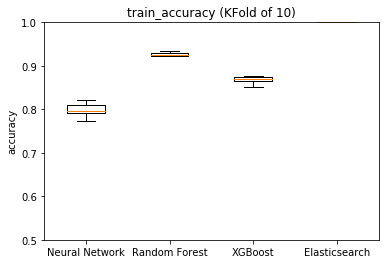

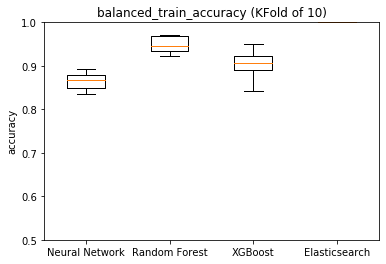

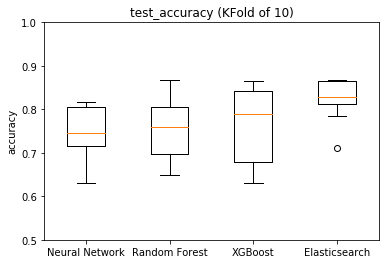

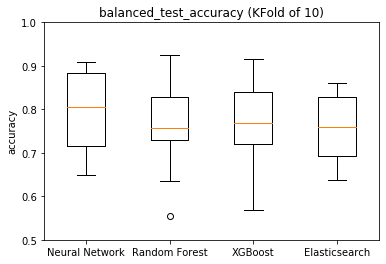

In [37]:
for metric in data_for_plotting:
    labels = []
    data = []
    for model, values in data_for_plotting[metric].items():
        labels.append(model)
        data.append(values)
    fig, ax = plt.subplots()
    ax.set_title(f'{metric} (KFold of 10)')
    ax.set_ylim([0.5, 1])
    ax.set_ylabel("accuracy")
    ax.boxplot(data, labels=labels)
    plt.show()